# Experiment on Combined Model (Copycat)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from skimage.filters import gaussian, sobel
from __future__ import print_function
from __future__ import division
import numpy as np
import os
import logging
import argparse
import pandas as pd
import sys
import shutil
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.layers import (Input, Activation, BatchNormalization, Conv2D,
                          Dense, Dropout, Flatten, GlobalAveragePooling2D,
                          GlobalMaxPooling2D, MaxPooling2D, Permute,
                          Reshape)
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from iceburger.io import parse_json_data,color_composite, smooth, denoise, grayscale
from iceburger.combined_model_train import (create_dataset, get_model_notebook, 
                                            combined_model, gen_flow_multi_inputs,
                                            train_model, gen_model_weights, train_models)
                                            

In [32]:
FORMAT =  '%(asctime)-15s %(name)-8s %(levelname)s %(message)s'
LOGNAME = 'iceburger-combined-train'

logging.basicConfig(format=FORMAT)
LOG = logging.getLogger(LOGNAME)
LOG.setLevel(logging.DEBUG)


In [3]:
train_all = True
# These are train flags that required to train model more efficiently and
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = True
clean_b = False or clean_all
clean_img = False or clean_all

load_all = True
load_b = False or load_all
load_img = False or load_all


In [25]:
PRJ = "/workspace/iceburger"
DATA = os.path.join(PRJ,"data/processed/train_valid_knn11_impute.json")
outpath="./"

In [34]:
model_out_path = os.path.join(os.path.abspath(outpath),"checkpoints")
os.path.exists(model_out_path)

True

In [30]:
y_train, X_b, X_images = create_dataset(DATA, True)

Denoising and reshaping
Gray 1 done
Gray 2 done
Gray 3 done


/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:94: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


RGB done


In [19]:
y_train_full, y_val,X_b_full, X_b_val,X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)


In [21]:
print(y_train_full.shape,y_val.shape,X_b_full.shape,X_b_val.shape,X_images_full.shape,X_images_val.shape)

(1443,) (161,) (1443, 75, 75, 3) (161, 75, 75, 3) (1443, 75, 75, 3) (161, 75, 75, 3)


In [22]:
y_train_train, y_test,X_b_train, X_b_test,X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)
print(y_train.shape,y_test.shape,X_b_train.shape,X_b_test.shape,X_images_train.shape,X_images_test.shape)

(1226,) (217,) (1226, 75, 75, 3) (217, 75, 75, 3) (1226, 75, 75, 3) (217, 75, 75, 3)


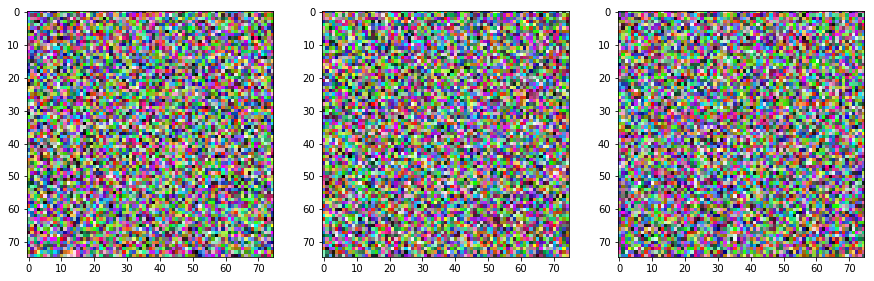

In [18]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_b)), 3, True)
chosen = X_b[random_indicies]
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(chosen[i])
plt.show()

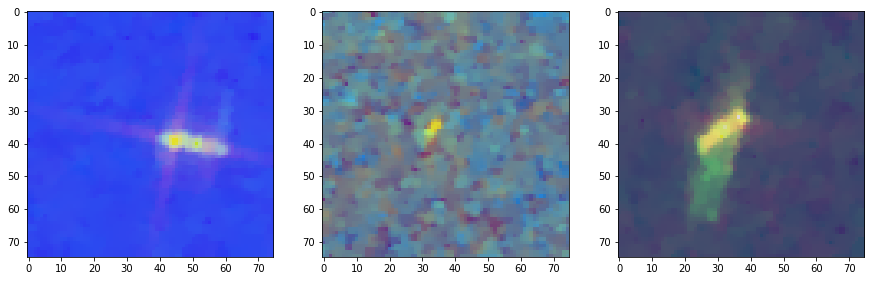

In [14]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 3, True)
chosen = X_images[random_indicies]
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(chosen[i])
plt.show()

In [15]:
lr = 1e-4
decay = 1e-4
channels = 3
relu = "relu"

model, partial_model = get_model_notebook(lr, decay, channels, relu)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
__________

In [17]:
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
__________

In [28]:
def train_models(outpath,dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train_train, X_b_test, y_test, X_b_val, y_val)
        LOG.info("Create callback functions")
        model_out_path = os.path.join(os.path.abspath(outpath),"checkpoints")
        if not os.path.exists(model_out_path):
            os.makedirs(model_out_path)
        checkpoint_name= "{mn}-best_val_loss.hdf5".format(mn="model_b")
        model_b_outpath = os.path.join(model_out_path, checkpoint_name)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, model_b_outpath,
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train_train, X_images_test, y_test, X_images_val, y_val)
        LOG.info("Create callback functions")
        model_out_path = os.path.join(os.path.abspath(outpath),"checkpoints")
        if not os.path.exists(model_out_path):
            os.makedirs(model_out_path)
        checkpoint_name= "{mn}-best_val_loss.hdf5".format(mn="model_img")
        model_img_outpath = os.path.join(model_out_path, checkpoint_name)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, model_img_outpath,
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        LOG.info("Create callback functions")
        model_out_path = os.path.join(os.path.abspath(outpath),"checkpoints")
        if not os.path.exists(model_out_path):
            os.makedirs(model_out_path)
        checkpoint_name= "{mn}-best_val_loss.hdf5".format(mn="model_common")
        model_common_outpath = os.path.join(model_out_path, checkpoint_name)
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint(model_common_outpath, save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath=model_common_outpath)
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)




In [33]:
common_model = train_models(outpath,(y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)


2017-12-19 16:17:32,140 iceburger-combined-train INFO Create callback functions


Training bandwidth network
Epoch 1/50
39/38 [==============================] - 11s 272ms/step - loss: 0.6640 - acc: 0.5789 - val_loss: 1.4576 - val_acc: 0.5392

2017-12-19 16:26:37,214 iceburger-combined-train INFO Create callback functions


Val/Train Loss: 0.330234234933/0.241220919355 Val/Train Acc: 0.863354037267/0.894009217963
Training image network
Epoch 1/50
39/38 [==============================] - 11s 279ms/step - loss: 0.6438 - acc: 0.6227 - val_loss: 0.7011 - val_acc: 0.4608

2017-12-19 16:35:46,543 iceburger-combined-train INFO Create callback functions


Training common network
Epoch 1/30
46/45 [==============================] - 25s 543ms/step - loss: 0.3198 - acc: 0.8559 - val_loss: 0.3267 - val_acc: 0.8385

In [36]:
test = pd.read_json('/workspace/iceburger/data/processed/test.json')
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [37]:
test["id"]

0       5941774d
1       4023181e
2       b20200e4
3       e7f018bb
4       4371c8c3
5       a8d9b1fd
6       29e7727e
7       92a51ffb
8       c769ac97
9       aee0547d
10      565b28ac
11      e04e9775
12      8e8161d1
13      4cf4d256
14      139e5324
15      f156976f
16      68a117cc
17      d9aa7a56
18      9005b143
19      5f6d3988
20      9ad70954
21      b9087b9e
22      a39a1427
23      82fbe8ed
24      1fae4879
25      6dd8f13d
26      bbad5958
27      54527583
28      be8fa29c
29      81a3328f
          ...   
8394    8ae30ce6
8395    de27ed88
8396    66d5196f
8397    d85f1858
8398    16dcb33a
8399    eca3158e
8400    08daeee6
8401    e9c513ee
8402    b1519fa6
8403    dfc89540
8404    8fd8c0e9
8405    45df6347
8406    bf7928d7
8407    7b587c05
8408    c2834388
8409    146143c3
8410    d59aee00
8411    cbc0b93b
8412    088e2ff7
8413    673d33cd
8414    674b031e
8415    43db4207
8416    156855e1
8417    ac96cfb0
8418    fe45aef5
8419    16ee9b50
8420    5a599eb7
8421    df30d6